## NMF-PY Detailed Walkthrough

#### Summary

The NMF-PY project is intended to replicate and expand upon the functionality of the EPA's PMF5 tool. The NMF-PY project will focus on open-source code written in Python using well known packages, such as Numpy and Pandas. 
The expected code products from the project include:

1. Python package (available on pypi.org)
2. Collection of Jupyter Notebooks (python code) as both tutorials and allowing users to use their own data in the notebooks.
3. Web application with similar features found in the PMF5 application.

PMF5 performs non-negative matrix factorization (NMF) calculating $V = WH$ while taking into consideration input uncertainty data, uncertainty of V. The common convention in current literature of NMF is different from PMF5, which refers to these matrices as V=X, W=G and H=F. We will use the current conventions for matrix labeling and notation. The data and uncertainty matrices are of size (M, N), M = the number of features/species and N = the number of samples. The number of factors/components is K. The H matrix is the factor/component profiles of size (K, M) and the W matrix is the factor/component contributions of size (N, K).

The matrix factorization uses a tool called the MultiLinear Engine 2 (ME2), a proprietary application, to solve the problem for a specified number of factors/components. The exact details of ME2 algorithm are currently unknown, except that the loss/minimization function as shown in the PMF5 users's manual is stated as:

$$ Q = \sum_{i=1}^n \sum_{j=1}^m \bigg[ \frac{V_{ij} - \sum_{k=1}^K W_{ik} H_{kj}}{U_{ij}} \bigg]^2 $$

which is the sum of a modified squared mean error (MSE) that considers the uncertainty of the input. Prior PMF versions, that used ME1, used a modified conjugate gradient algorithm that iteratively checks for the optimial update step size and direction. The algorithm used in ME2 is assumed to be an updated, or further modified, version of the ME1 algorithm. 



#### NMF-PY Workflow

The primary focus of the current work is to develop a workflow that minimizes the loss value, Q, to as close as possible as the report PMF5 Q value and to then compare the results of the factor profiles. The workflow of this comparison of PMF5 to NMF-PY involves the following steps:

1. Data import and clean up (using the three provided example datasets from PMF5) - Pre-processing
    1. Import and convert data files into Pandas DataFrames
    2. Drop features/species which contain no data
    3. Drop samples with NAN or empty data, no interpolation being done (future feature)
2. Set the parameters for NMF-src.
    1. The number of factors, K.
    2. The random seed.
    3. The update algorithm to use.
    4. The maximum number of iterations.
    5. The number of epochs/models.
    6. The convergence critera.
        1. The change of loss Q, delta Q.
        2. The number of iterations where the change in Q is less than delta Q.
3. Initialize the W and H matrices
    1. A common approach is to initialize these matrices to random uniform values, (0, 1], multiplied by $\sqrt{\frac{V_{mean}}{K}}$.
4. Iterate a specified algorithm updating W and H to minimize the loss function.
    1. Algorithm 1: Weighted Kullback-Leibler divergence (kl)
    2. Algorithm 2: Least-Squares NMF (ls-nmf)
    3. These algorithms have a reset feature, which falls back to a previous best Q model state and attempts to update W and H with a reduced weight when Q increases over a specified number of iterations. The justification of this feature is stated later.
5. Compare the output of NMF-PY to the output of PMF5 - Post-processing
    1. The factor profile of each model from NMF-PY is compared to the output of the best model from PMF5, using the coeffecient of determination $R^2$ as the comparison metric.
        1. All permutations of the factor profiles for each model output of NMF-PY are mapped and compared to the PMF5 output factor profiles.
    2. The best model is reported as determined by the highest average $R^2$ of all mapped factor profiles.

#### Python Setup

Python imports used for processing of data in this notebook.

In [1]:
import os
import sys
import copy
import logging
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from esat.data.datahandler import DataHandler
from esat.model.base_nmf import BaseSearch
from tests.factor_comparison import FactorComp
from esat.model.optimization import ComponentSearch
from esat.utils import calculate_Q

#### Input and Uncertainty Data

Using the PMF5 provided input data files for comparing the outputs. This example is using the input files for the Baton Rouge dataset.

In [2]:
input_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-BatonRouge-con.csv")
uncertainty_file = os.path.join("D:\\", "projects", "nmf_py", "data", "Dataset-BatonRouge-unc.csv")
output_path = os.path.join("D:\\", "projects", "nmf_py", "output", "BatonRouge")

#### Data Handler Setup

Stage 1 of the workflow, data preparation. The data handling will eventually be integrated into the model declaration to simplify use of the python code.

In [3]:
dh = DataHandler(
        input_path=input_file,
        uncertainty_path=uncertainty_file,
        output_path=output_path,
        index_col='Date'
    )

07-Apr-23 08:41:36 - Input and output configured successfully


Input data metrics as shown in PMF5, Category is currently just set to 'Strong' by default.

In [4]:
dh.metrics

,Category,S/N,Min,25th,50th,75th,Max
124-Trimethylbenzene,Strong,5.445168,0.005000,0.820001,1.290001,1.865001,5.470003
224-Trimethylpentane,Strong,5.666667,0.410000,1.580001,2.490002,3.865002,13.560008
234-Trimethylpentane,Strong,5.537459,0.005000,0.530000,0.820001,1.300001,4.410003
23-Dimethylbutane,Strong,5.500543,0.005000,0.640000,1.110001,2.285001,10.500007
23-Dimethylpentane,Strong,5.463626,0.005000,0.340000,0.490000,0.780000,3.310002
2-Methylheptane,Strong,5.039088,0.005000,0.215000,0.330000,0.535000,2.480002
3-Methylhexane,Strong,5.648208,0.005000,0.655000,1.050001,1.510001,7.780005
3-Methylpentane,Strong,5.611292,0.540000,1.720001,2.990002,5.945004,29.100018
Acetylene,Strong,5.666667,0.380000,1.410001,1.990001,2.835002,8.070005
Benzene,Strong,5.666667,0.590000,1.960001,2.770002,4.440003,9.330006


#### Set Parameters

Stage 2 of the workflow, the hyper-parameters for the model runs and and setting up of the initial model state.

In [5]:
n_components = 4             # number of factors
method1 = "kl"               # minimization algorithm: 'kl' multiplicative update - Kullback-Leibler, 'euc' multiplicative update - Frobenius
seed = 42                    # randomization seed
epochs = 20                  # number of models to create
max_iterations = 20000       # max number of iterations to run for multiplicative update models
converge_delta = 0.1         # the amount of change between iterations for a multiplicative model considered converged
converge_n = 100             # the number of iterations required with a loss change of less than converge_delta for the model to be considered converged

Set the processed input and uncertainty data to the input variables (to simplify code)

In [6]:
V = dh.input_data_processed
U = dh.uncertainty_data_processed

#### The Weighted Kullback-Leibler Divergence Algorithm.

Stage 3 and 4 of the workflow. This example is using the Kullback-Leibler (kl) algorithm, creating 5 independent models (using different seeds to initialize W and H), with a max of 20,000 iteration, a Q delta of 1.0 over 100 steps for convergence (the low delta and convergence n are only for speeding up the runtime of this notebook model run). The standard kl algorithm is found in most NMF code packages (in both R and Python) and is documented in publications found at:

* Algorithms for Nonnegative Matrix Factorization with the Kullback-Leibler Divergence: https://www.semanticscholar.org/reader/7175ba6d298a2778da0cc8f00f99b11457931661
* Fast Local Algorithms for Large Scale Nonnegative Matrix and Tensor Factorization: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=4229f467b059188fc7a1234016a3c80557fa7df0
* Algorithms for nonnegative matrix factorization with the β-divergence: https://arxiv.org/pdf/1010.1763.pdf
* **Weighted Nonnegative Matrix Factorization and Face Feature Extraction**: https://perso.uclouvain.be/paul.vandooren/publications/BlondelHV07.pdf

The last publication describes the algorithm currently implemented in NMF-PY for kl, as defined by Theorem 5. The update algorithm for kl is:

$$ H_{t+1} = \frac{H_t}{W^T_t U^{-1}} \circ \bigg(W_t^T \frac{U^{-1}\circ V}{W_t H_t} \bigg) $$


$$ W_{t+1} = \frac{W_t}{U^{-1} H^T_{t+1}} \circ \bigg(\frac{U^{-1}\circ V}{W_t H_{t+1}} H_{t+1}^T \bigg) $$

In [7]:
base = BaseSearch(n_components=n_components, method=method1, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base.parallel_train()

07-Apr-23 08:17:58 - Results - Best Model: 17, Converged: True, Q: 103406.59322418412
07-Apr-23 08:17:58 - Runtime: 0.3 min(s)


In [8]:
save_output_path1 = f"{method1}-e{epochs}-c{n_components}-br.json"
base.save(output_name=save_output_path1)

07-Apr-23 08:20:39 - Results saved to: .\kl-e20-c4-br.json


In [9]:
pmf_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"baton-rouge_{n_components}f_profiles.txt")
pmf_residuals_file = os.path.join("D:\\", "projects", "nmf_py", "data", f"baton-rouge_{n_components}f_residuals.txt")
profile_comparison = FactorComp(nmf_output=save_output_path1, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
pmf_q = calculate_Q(profile_comparison.pmf_residuals.values, dh.uncertainty_data_processed)
profile_comparison.compare(PMF_Q=pmf_q)

Calculating correlation between factors from each epoch: 100%|█████████████████████████| 20/20 [00:00<00:00, 83.24it/s]
Calculating average correlation for all permutations for each epoch: 100%|███████████| 20/20 [00:00<00:00, 1666.95it/s]

R2 - Model: 2, Best permutations: ['Factor 3', 'Factor 1', 'Factor 2', 'Factor 4'], Average: 0.9919598760748133, Factors: [0.9972172280227584, 0.9880211238077514, 0.9838827999741433, 0.9987183524945998]
PMF5 Q(true): 86973.578125, NMF-PY Model 2 Q(true): 112507.7091039012


#### The Least-Squares NMF Algorithm

Stage 3 and 4 or the workflow. The next example uses the weighted least-squares divergence (ls-nmf), creating 5 independent models (using different seeds to initialize W and H), with a max of 20,000 iteration, a Q delta of 1.0 over 100 steps for convergence (the low delta and convergence n are only for speeding up the runtime of this notebook model run). The ls-nmf algorithm is also defined as the weighted euclidean difference algorithm. The ls-nmf algorithm is documented in publications:

* **LS-NMF: A modified non-negative matrix factorization algorithm utilizing uncertainty estimates**: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-175
* Weighted Nonnegative Matrix Factorization and Face Feature Extraction: https://perso.uclouvain.be/paul.vandooren/publications/BlondelHV07.pdf
* NONNEGATIVE MATRIX FACTORIZATION (NMF) WITH HETEROSCEDASTIC UNCERTAINTIES AND MISSING DATA: https://arxiv.org/pdf/1612.06037.pdf

The publication describes the algorithm currently implemented in NMF-PY for ls-nmf. The last publication describes the algorithm currently implemented in NMF-PY for euc, as defined by Theorem 4. The update algorithm for fl is:

$$ H_{t+1} = H_t \circ \frac{W_t \frac{V}{U}}{W_t \frac{W_tH_t}{U}} $$

$$ W_{t+1} = W_t \circ \frac{\frac{V}{U} H_{t+1}}{\frac{W_tH_{t+1}}{U}H_{t+1}} $$

In [10]:
method2 = "ls-nmf"
base2 = BaseSearch(n_components=n_components, method=method2, V=V, U=U, seed=seed, epochs=epochs, max_iterations=max_iterations, converge_delta=converge_delta, converge_n=converge_n)
base2.parallel_train()

07-Apr-23 08:25:16 - Results - Best Model: 2, Converged: True, Q: 176757.11186813767
07-Apr-23 08:25:16 - Runtime: 0.84 min(s)


In [11]:
save_output_path2 = f"{method2}-e{epochs}-c{n_components}-br.json"
base2.save(output_name=save_output_path2)

07-Apr-23 08:25:26 - Results saved to: .\ls-nmf-e20-c4-br.json


In [12]:
profile_comparison3 = FactorComp(nmf_output=save_output_path2, pmf_output=pmf_file, factors=n_components, species=len(dh.features), residuals_path=pmf_residuals_file)
profile_comparison3.compare(PMF_Q=pmf_q)

Calculating correlation between factors from each epoch: 100%|████████████████████████| 20/20 [00:00<00:00, 111.71it/s]
Calculating average correlation for all permutations for each epoch: 100%|███████████| 20/20 [00:00<00:00, 1992.12it/s]

R2 - Model: 13, Best permutations: ['Factor 4', 'Factor 3', 'Factor 2', 'Factor 1'], Average: 0.9523589041164898, Factors: [0.8744629024121336, 0.98609508536856, 0.9602608705536003, 0.9886167581316655]
PMF5 Q(true): 86973.578125, NMF-PY Model 13 Q(true): 190452.1868121923


#### Optimal Component Search

We have implemented a procedure for quickly testing a range of factors to see the impact on the Q loss value. The method currently uses the default algorithm (kl).

In [9]:
min_component = 2
max_component = 20
max_iterations = 1000
epochs = 20
converge_diff = 1
converge_iter = 100

cs = ComponentSearch(seed=seed, datahandler=dh)
cs.search(min_component=min_component, max_component=max_component, max_iterations=max_iterations, epochs=epochs, converge_diff=converge_diff, converge_iter=converge_iter)

07-Apr-23 08:44:03 - Results - N Factors: 2, Best Model: 5, Q: 145453.09341609728
07-Apr-23 08:44:03 - Runtime: 0.15 min(s)
07-Apr-23 08:44:19 - Results - N Factors: 3, Best Model: 15, Q: 120316.3706436011
07-Apr-23 08:44:19 - Runtime: 0.27 min(s)
07-Apr-23 08:44:35 - Results - N Factors: 4, Best Model: 17, Q: 103406.59322418412
07-Apr-23 08:44:35 - Runtime: 0.26 min(s)
07-Apr-23 08:44:51 - Results - N Factors: 5, Best Model: 9, Q: 91557.52361110342
07-Apr-23 08:44:51 - Runtime: 0.28 min(s)
07-Apr-23 08:45:08 - Results - N Factors: 6, Best Model: 5, Q: 80560.08476807846
07-Apr-23 08:45:08 - Runtime: 0.28 min(s)
07-Apr-23 08:45:25 - Results - N Factors: 7, Best Model: 9, Q: 71333.98622612366
07-Apr-23 08:45:25 - Runtime: 0.28 min(s)
07-Apr-23 08:45:42 - Results - N Factors: 8, Best Model: 0, Q: 62967.37953006233
07-Apr-23 08:45:42 - Runtime: 0.28 min(s)
07-Apr-23 08:46:00 - Results - N Factors: 9, Best Model: 16, Q: 57456.821603976765
07-Apr-23 08:46:00 - Runtime: 0.3 min(s)
07-Apr-23 0

07-Apr-23 08:50:43 - Loaded backend module://matplotlib_inline.backend_inline version unknown.


<AxesSubplot: xlabel='component'>

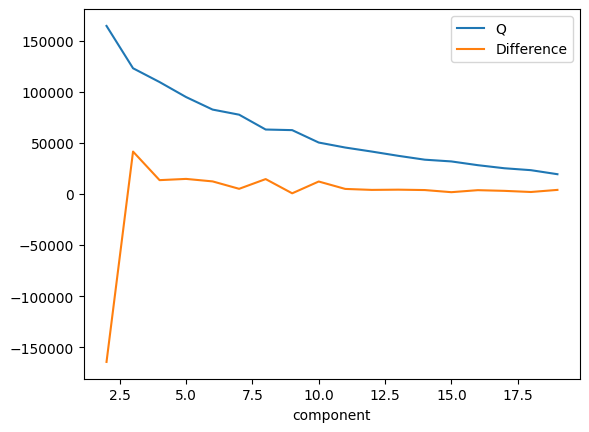

In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

D = []
q_0 = 0
for q in cs.Q:
    D.append(q_0 - q)
    q_0 = q

df = pd.DataFrame(dict(component=range(min_component, max_component), Q=cs.Q, Difference=D))
df.plot(x='component', y=['Q', 'Difference'])

#### Factor Comparison

The prior examples show the results of several algorithms in comparison to PMF5 output but only for 4 components. The following shows a comparison between the default algorithm (kl) against PMF5 for a range of different component counts.

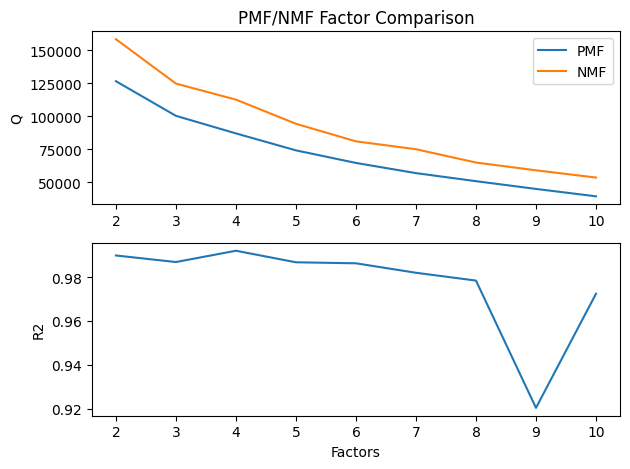

In [11]:
min_components = 2
max_components = 10

results_data = []
output_path = os.path.join("D:\\", "projects", "nmf_py", "data", "factor_test")
columns = None


for n_components in range(min_components, max_components+1):
    comparison_file = f"br{n_components}f_profiling_results.json"
    results_file = os.path.join(output_path, comparison_file)
    with open(results_file) as file:
        file_results = json.load(file)
        columns = file_results.keys()
        results_data.append(file_results)
results = pd.DataFrame(results_data, columns=columns)

warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

fig, axs = plt.subplots(2, 1)
axs[0].plot(results["factors"], results["pmf-Q"], label="PMF")
axs[0].plot(results["factors"], results["nmf-Q"], label="NMF")
axs[1].plot(results["factors"], results["R2 Avg"])
axs[1].set_xlabel("Factors")
axs[0].set_ylabel("Q")
axs[1].set_ylabel("R2")
axs[0].legend()
axs[0].set_title("PMF/NMF Factor Comparison")
fig.tight_layout()

plt.show()

#### Large Dataset - Options

A limitation of the PMF5 tool is its inability to handle large datasets. The first aspect of this limitation is the maximum equation count that PMF5 allows (?) and the second aspect is that running matrix-factorization on large datasets is computationally intensive. There are some updated algorithms which may help address these issues, but none that have been verified at this time. Alternative approaches could partially help resolve the issue of running NMF on large datasets, greatly reducing run time while focusing on generating a factor profile that minimizes the loss function.

##### Batch Models

The primary goal of NMF is to find a factor/component profile (H matrix) which produces the smallest loss value then one possible approach could be batch modeling. The batch modeling approach is analogous to common machine learning pipelines that frequently must handle large amounts of training data in the model fitting process. The details of the pipeline for the NMF batch model option:

1. Separate the dataset into batches, with a maximum batch size set to reduce the computational complexity of the processing and limit the maximum amount of memory used.
2. Approach 1 (traditional ML workflow)
    1. Create a model and iteratively train the model on each batch.
    2. Repeat the process on the dataset batches for a specified number of times (epoches). Each epoch is a separate model using the output of the previous epoch as the starting point/initial values of W/H, with the sequence of batches randomized.
        1. This approach differs from the currently implemented PMF/NMF algorithms as each epoch is currently completely independent of each other, with each epoch randomly initializing the W and H matrices.
3. Approach 2 (Parallelizable)
    1. Create a model for each training batch.
    2. Repeat the fit of each model on each training batch. A single epoch would result in N, # of batches, models trained on a different batches to cover the entire dataset.
    3. Repeat the process of approach 1.2, for each model until a maximum number of epochs has been completed or a specified stopping condition has been reached.
4. Approach 3 (Parallelizable, "genetic-algorithm")
    1. Approach 2, but between each epoch the model factor profiles (H) are merged with weights by rank (higher weight for lower loss) and keep the N lowest loss models for next epoch.
    2. Alternatively, the selection process could drop a percentage of worst performing models and copy the best models by that same percentage (minus some model count decay percentage) and run those duplicated models on different batches of the data. (No merging)
        1. This approach would then run until an epoch fit results in minimal change to the resulting Q loss value and/or only one model remains.
4. Models are evaluated on the entire dataset, where the H matrices are used to generate the W matrix and the residuals used to calculate total loss. The end result is a factor/component profile which has been trained on the entire dataset and can then be used to generate a full component contribution matrix and residuals.

In approaches 2 and 3, the batches can be trained in parallel as they are each independent models.

#### Pre-Processing Features

The current focus of development is on the base NMF algorithm, with the best results found with the weighted Kullback-Liebler algorithm. Some potential features have been considered by the team which we believe could help facilitate the utility of the new NMF tool.

1. More customizable handling of missing data.
    1. Imputation strategies for missing values or rows
    2. More automated detection of incompatable values in the data (non-numeric or categorical data types)
2. Modifying the data based upon the signal/noise ratio (S/N)
    1. Notify the user when a feature/species (column) of the dataset has an average S/N value below a defined threshold (such as 2.0) and recommend excluding the column during processing, a high uncertainty increases the difficulty of finding a converging local minimum.
    2. Notify the user when a sample of the dataset has an average S/N value below the defined threshold, could be the result of other sources of uncertainty being considered for a specific sample.
    3. We are currently investigating some approaches for handling high S/N data points in the algorithm directly to reduce the negative impact these values can have on the solution.
3. Automatically generate randomized uncertainty from the input data based upon a percentage range (such as between 5-7%) when none is provided.
4. Providing the user with the recommended number of factors based upon the factor comparison method shown above, where the optimal number of factors could be determined by the % change in Q between factors being below some threshold.

The selection of features to implement will be primarily determined from user community feedback and requests, with these items only forming the initial feature list.

#### Post-Processing Features

Once the algorithm(s) have been finalized, we will proceed with developing the uncertainty analysis methods and visualizations that have been implemented in PMF5. The details of those features will be reviewed and discussed at a later time. We are also wanting to hear from the user community on what could be some helpful post-processing features which are not included in PMF5.

One potential post-processing feature that we have considered is cross-model factor analysis. Here we would take the results from N number of epochs/model runs and compare the factor profiles between each model. The factor comparison could be similiar to how we are currently comparing PMF5 factors to NMF factors, calculating $R^2$ for each factor of PMF to all other factors in the NMF models. The idea would be to provide distributions of like factors across the model runs looking for trends or frequently occuring factors. Using parallelization to create a high number of models with random initialization, we are essentially running a Monte Carlo analysis of the factors. Potentially we could select some number of separable factors from the analysis and use those profiles as the initial value for a new run of NMF, to see about further reducing the loss function through the selective initilaization of H. We have not investigated this approach at this time, though this approach could also be used with the batch modeling approach.


#### Current Issues

##### PMF5 Algorithm

The PMF5 tool uses the proprietary Multi-Linear Enginer 2 (ME2) solver, an executable which manages all the non-negative matrix factorization operations. The exact algorithm used by ME2 is not known at this time, although we do have the 'pseudocode' that is used in the ME1 solver. The details of the algorithm are available in the publication <i>The Multilinear Engine-A Table-Driven, Least Squares Program for Solving Multilinear Problems, Including the n-Way Parallel Factor Analysis Model</i> section 7.1, pg 876-877. The algorithm is a modified linear conjugate gradient algorithm, which considers the uncertainty data in the calculations of the gradients to update the W and H matrices. Because the algorithm of ME2 is unknown, we approach this as a black-box problem where exactly replication of the output of PMF5 may not be possible with the information we have. 

##### Issues with NMF-PY Algorithms

There are few alternative algorithms for calculating NMF with the consideration of weights or uncertainty, with several having been implemented and modified beyond the published algorithm to reduce overall loss. The few that we have implemented run into an issue of the update steps not guaranteeing convergence, the update to the W and H matrices is not guaranteed to continuously reduce the loss value. In the publications it is often stated that these algorithms converge that is not what we have found when implemented and used with the PMF5 test datasets. To handle this issue, we watch the change in loss and have two features for returning the best results:

1. When the loss increases over a certain number of steps we revert back to the current best solution and reduce an update coefficient to reduce the change to the W and H matrices over future steps (reduce step size).
2. Once the revert feature is done a certain number of times, the maximum number of steps reached, or the change in Q is below a threshold over a certain number of steps, we return the best results found by the algorithm.

We will continue to investigate updates and alternatives to these algorithms to attempt to further reduce the output loss of the models. With the current output of the Kullback-Leibler algorithm, we see similar results to PMF5 with a consistently larger loss in NMF (which may be the result of some modification to the dataset being used in PMF5, since the difference appears to be a consistent percentage of PMF5 and could be related to data masking or some other S/N or outlier handling). 

#### Future Direction

Our current project plane and direction follow several stages of development, with multiple resulting products.

##### Initial Development (Current Stage)

The development and validation of the base algorithm(s) with a comparison to the PMF5 as the primary metric. The code base will be in Python using only numpy and pandas, attempting to minimize dependencies. 

##### Complete Feature Development

Once the base features have been implemented, we will focus on the remaining features from PMF5 which have been request for the new code/tool. The output of this stage will be open source python code, web documentation (User's Manual), and package available from pypi (public python package repository) with the code containing walkthrough and demonstration Jupyter notebooks for executing the full set of available functionality.

##### Development of Cloud-Based Tool

The code package that has been developed to this point will then be used as the primary processing backend of a containerized web tool to be deployed to the cloud (AWS). The tool would by a dynamic web application (Angular) and provide a highly interactive user interface for data pre-processing, execution of the modeling process, and post-processing. 